In [1]:
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods 
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
import requests, zipfile, io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBClassifier,plot_importance
from sklearn.metrics import explained_variance_score,confusion_matrix,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,classification_report, confusion_matrix, accuracy_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import linear_model, tree, ensemble
borough_list=pd.DataFrame(pd.read_excel('districts.xls'))
borough_list.rename(columns = {'District':'Borough_name','Ceremonial County':'County'}, inplace = True)
borough_list = borough_list.applymap(lambda s: s.lower() if type(s) == str else s)
c_b = borough_list.Borough_name.values.tolist()

In [2]:

### Housing Data ###

### Housing Data ###
housing_19 = pd.DataFrame(pd.read_csv('http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2019.csv',nrows=100000,usecols =[0,1,2,3,4,5,6,12,13],header = None))
column_names=['sale_id','price','date','postcode','house_type','new_build','lease_type','Borough_name','County']
housing_19.columns = column_names

housing_20 = pd.DataFrame(pd.read_csv('http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2020.csv',nrows=100000,usecols =[0,1,2,3,4,5,6,12,13],header = None))
column_names=['sale_id','price','date','postcode','house_type','new_build','lease_type','Borough_name','County']
housing_20.columns = column_names

housing_21 = pd.DataFrame(pd.read_csv('http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2021.csv',nrows=100000,usecols =[0,1,2,3,4,5,6,12,13],header = None))
column_names=['sale_id','price','date','postcode','house_type','new_build','lease_type','Borough_name','County']
housing_21.columns = column_names

#housing_22 = pd.DataFrame(pd.read_csv('http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2022.csv.csv',usecols =[0,1,2,3,4,5,6,12,13],header = None))
#column_names=['sale_id','price','date','postcode','house_type','new_build','lease_type','Borough_name','County']
#housing_22.columns = column_names

df1=pd.concat([housing_19,housing_20,housing_21])

#df1 = pd.DataFrame(pd.read_excel('pp-2022.xlsx',usecols =[0,1,2,3,4,5,6,12,13],header = None))
column_names=['sale_id','price','date','postcode','house_type','new_build','lease_type','Borough_name','County']
df1.columns = column_names
df1['date'] = pd.to_datetime(df1['date'])
#df1 = df1.loc[(df1['date'] >= '2019-01-01') & (df1['date'] < '2022-08-01')]
df1['year'] = pd.DatetimeIndex(df1['date']).year
df1['month'] = pd.DatetimeIndex(df1['date']).month
df1 = df1.applymap(lambda s: s.lower() if type(s) == str else s)
#df1['[price]'] = df1['price'].astype('int')
c=['bedford','buckinghamshire','cambridgeshire','cheshire east', 'cheshire west and chester','cleveland','cornwall','cumbria','derbyshire','devon','dorset','durham','east sussex','essex','gloucestershire','greater london','greater manchester','hampshire','hertfordshire','kent','lancashire','leicestershire','lincolnshire', 'north east lincolnshire', 'north lincolnshire', 'merseyside','norfolk','north yorkshire','northamptonshire', 'north northamptonshire','northumberland','nottinghamshire','oxfordshire','shropshire','somerset', 'north somerset','south yorkshire','south gloucestershire', 'staffordshire','suffolk','surrey','tyne and wear','warwickshire','west berkshire','west midlands','west sussex','west yorkshire','wiltshire','worcestershire']
df1=df1[df1['County'].isin(c)]
df1=df1[df1['Borough_name'].isin(c_b)]

df1 = df1[df1['house_type'] != 'o'].copy()
#df1['price'] = df['Weight'].astype(int)


### Clinics Data ###
df2 = pd.DataFrame(pd.read_csv ('Clinics.csv',encoding= 'latin1',sep='¬'))
df2.rename(columns = {'City':'Borough_name'}, inplace = True)
df2=df2.drop_duplicates(subset='Address1',keep="last")
#df2 = df2.dropna(subset=['Borough_name'])
df2 = df2.applymap(lambda s: s.lower() if type(s) == str else s)
df2=df2[df2['Borough_name'].isin(c_b)]
#clinics_count= pd.value_counts(df2['Borough_name'].values).rename_axis('Borough_name').reset_index(name='clinics_count')
df2 = df2.groupby(['Borough_name'])['Borough_name'].count().reset_index(name='clinics_count')
#df2 = df.groupby(['Courses','Duration']).size().reset_index(name='counts')
df2=pd.DataFrame(df2)


### School Data ###
school_url='https://www.find-school-performance-data.service.gov.uk/download-data?download=true&regions=0&filters=GIAS&fileformat=xls&year=2021-2022&meta=false'
df3= pd.DataFrame(pd.read_excel(school_url))
df3.rename(columns = {'TOWN':'Borough_name'}, inplace = True)
df3=df3.drop_duplicates(subset='LOCALITY',keep="last")
df3 = df3.applymap(lambda s: s.lower() if type(s) == str else s)
df3=df3[df3['Borough_name'].isin(c_b)]
df3 = df3.groupby(['Borough_name'])['Borough_name'].count().reset_index(name='schools_count')


### Hospital Data ###
df4 = pd.DataFrame(pd.read_csv ('Hospital.csv',encoding= 'latin1',sep='¬'))
df4.rename(columns = {'City':'Borough_name'}, inplace = True)
df4=df4.drop_duplicates(subset='Address1',keep="last")
df4 = df4.applymap(lambda s: s.lower() if type(s) == str else s)

df4=df4[df4['Borough_name'].isin(c_b)]
#clinics_count= pd.value_counts(df2['Borough_name'].values).rename_axis('Borough_name').reset_index(name='clinics_count')
df4 = df4.groupby(['Borough_name'])['Borough_name'].count().reset_index(name='hospital_count')


### Pubs Data ###

pubs_url = 'https://www.getthedata.com/downloads/open_pubs.csv.zip'
filename = 'open_pubs.csv'

r = requests.get(pubs_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

columns=['ID','pub_name','area_name','postcode','a','x','y','z','Borough_name']
df5 = pd.read_csv(filename, sep=',',header=None,names=columns)
df5=df5.drop_duplicates(subset='area_name',keep="last")
df5 = df5.applymap(lambda s: s.lower() if type(s) == str else s)
df5=df5[df5['Borough_name'].isin(c_b)]
#clinics_count= pd.value_counts(df2['Borough_name'].values).rename_axis('Borough_name').reset_index(name='clinics_count')
df5 = df5.groupby(['Borough_name'])['Borough_name'].count().reset_index(name='pubs_count')



### GP Data ###
df6 = pd.DataFrame(pd.read_csv ('GPPractices.csv',encoding= 'latin1',sep='¬'))
df6.rename(columns = {'City':'Borough_name'}, inplace = True)
df6 = df6.applymap(lambda s: s.lower() if type(s) == str else s)
df6=df6[df6['Borough_name'].isin(c_b)]
#clinics_count= pd.value_counts(df2['Borough_name'].values).rename_axis('Borough_name').reset_index(name='clinics_count')
df6 = df6.groupby(['Borough_name'])['Borough_name'].count().reset_index(name='gp_count')



### Deprivation Data ###

deprivation_url='https://opendata.camden.gov.uk/api/views/8x5x-eu22/rows.csv'
df7 = pd.DataFrame(pd.read_csv(deprivation_url, usecols =[3,10,14,26]))
df7.rename(columns = {'Local Authority District Name':'Borough_name'}, inplace=True)
df7 = df7.applymap(lambda s: s.lower() if type(s) == str else s)
df7=df7[df7['Borough_name'].isin(c_b)]
### Population Data ###

df8=pd.DataFrame(pd.read_excel('census2021firstresultsenglandwales1.xlsx',sheet_name='P01',skiprows=6,usecols=[1,2]))
df8.rename(columns = {'Area name':'Borough_name','All persons':'population'}, inplace = True)### Rename primary key ###
df8 = df8.applymap(lambda s: s.lower() if type(s) == str else s)
df8=df8[df8['Borough_name'].isin(c_b)]
### Parks Data ###

df9=pd.DataFrame(pd.read_excel('ospublicgreenspacereferencetables.xlsx',sheet_name='LAD Parks only',usecols=[5,6,8]))
df9.rename(columns = {'LAD name':'Borough_name','Average distance to nearest Park, Public Garden, or Playing Field (m)':'Avg_distance_to_park','Average number of  Parks, Public Gardens, or Playing Fields within 1,000 m radius':'avg_number_of_parks'}, inplace = True)### Rename primary key ###
df9 = df9.applymap(lambda s: s.lower() if type(s) == str else s)
df9=df9[df9['Borough_name'].isin(c_b)]

df11=pd.DataFrame(pd.read_excel('https://simplemaps.com/static/data/country-cities/gb/gb.xlsx',usecols=[0,1,2]))
df11.rename(columns={'city':'Borough_name'},inplace=True)
df11 = df11.applymap(lambda s: s.lower() if type(s) == str else s)
df11=df11.query("Borough_name in @c_b")
df11=df11[df11['Borough_name'].isin(c_b)]
#clinics_count= pd.value_counts(df2['Borough_name'].values).rename_axis('Borough_name').reset_index(name='clinics_count')

df12 = pd.DataFrame(pd.read_csv('Sales-2022-09.csv',usecols =[0,1,3],header = 0))
df12.rename(columns = {'Region_Name':'Borough_name','Date':'date','Sales_volume':'sales_volume'}, inplace = True)

df12['date'] = pd.to_datetime(df12['date'])

df12 = df12.loc[(df12['date'] >= '2019-01-01') & (df12['date'] < '2022-08-01')]
df12['year'] = pd.DatetimeIndex(df12['date']).year
df12['month'] = pd.DatetimeIndex(df12['date']).month
df12 = df12.applymap(lambda s: s.lower() if type(s) == str else s)
#df1['[price]'] = df1['price'].astype('int')

df12=df12[df12['Borough_name'].isin(c_b)]

df13 = pd.DataFrame(pd.read_csv('Cash-mortgage-sales-2022-09.csv',usecols =[0,1,7,12],header = 0))
df13.rename(columns = {'Region_Name':'Borough_name','Date':'date','Sales_volume':'sales_volume'}, inplace = True)

df13['date'] = pd.to_datetime(df13['date'])

df13 = df13.loc[(df13['date'] >= '2019-01-01') & (df13['date'] < '2022-08-01')]
df13['year'] = pd.DatetimeIndex(df13['date']).year
df13['month'] = pd.DatetimeIndex(df13['date']).month
df13 = df13.applymap(lambda s: s.lower() if type(s) == str else s)
#df1['[price]'] = df1['price'].astype('int')

df13=df13[df13['Borough_name'].isin(c_b)]




/var/folders/12/3shw3j8s0g7_1_d_tn16p4980000gn/T/ipykernel_20897/896751299.py:40: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df2 = pd.DataFrame(pd.read_csv ('Clinics.csv',encoding= 'latin1',sep='¬'))
/var/folders/12/3shw3j8s0g7_1_d_tn16p4980000gn/T/ipykernel_20897/896751299.py:63: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df4 = pd.DataFrame(pd.read_csv ('Hospital.csv',encoding= 'latin1',sep='¬'))
/var/folders/12/3shw3j8s0g7_1_d_tn16p4980000gn/T/ipykernel_20897/896751299.py:93: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; 

In [3]:
final_data=pd.merge(df1, df12, how="left", on=['month','year','Borough_name'])
final_data=pd.merge(final_data, df13, how="left", on=['month','year','Borough_name'])
final_data = pd.merge(final_data, df2, how="left", on="Borough_name")
final_data=pd.merge(final_data, df3, how="left", on="Borough_name")
final_data=pd.merge(final_data, df4, how="left", on="Borough_name")
final_data=pd.merge(final_data, df5, how="left", on="Borough_name")
final_data=pd.merge(final_data, df6, how="left", on="Borough_name")
final_data=pd.merge(final_data, df7, how="left", on="Borough_name")
final_data=pd.merge(final_data, df8, how="left", on="Borough_name")
final_data=pd.merge(final_data, df9, how="left", on="Borough_name")
final_data=pd.merge(final_data, df11, how="left", on="Borough_name")

df=final_data.copy()
df=df.drop_duplicates(subset='sale_id',keep="last")
df=df.drop_duplicates()
#df['price'] = df['price'].astype('int')

#df=pd.DataFrame(pd.read_excel('housing_test.xlsx', index_col=0))
#df=df.dropna()
df.fillna(df.median(), inplace=True)

cols = ['price',  'Cash_Sales_Volume', 'Mortgage_Sales_Volume',
        'Income Decile', 'Emplyment Decile', 'Crime Decile',
       'population', 'Avg_distance_to_park', 'avg_number_of_parks']# one or more

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

df=df[['Borough_name','County','price', 'house_type', 'new_build',
       'lease_type', 'Cash_Sales_Volume', 'Mortgage_Sales_Volume',
       'clinics_count', 'schools_count', 'hospital_count', 'pubs_count',
       'gp_count', 'Income Decile', 'Emplyment Decile', 'Crime Decile',
       'population', 'Avg_distance_to_park', 'avg_number_of_parks', 'lat',
       'lng']]

for column in df[['lease_type','house_type','new_build']].columns:
    df[column] = df[column].astype('category')
    df[column] = df[column].cat.codes

df.drop(df[df['price'] <= 10000].index, inplace = True)
df.drop(df[df['price'] >= 700000].index, inplace = True) 

df.dropna()
df.to_csv('cleaned_data.csv')



/var/folders/12/3shw3j8s0g7_1_d_tn16p4980000gn/T/ipykernel_20897/266754552.py:20: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.median(), inplace=True)
/var/folders/12/3shw3j8s0g7_1_d_tn16p4980000gn/T/ipykernel_20897/266754552.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.median(), inplace=True)


In [4]:
#df=pd.read_csv('cleaned_data.csv')

X = df.drop(columns=['Borough_name','County','price'])
y = df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20)

In [5]:
from sklearn.model_selection import KFold
X = df.drop(columns=['Borough_name','County','price'])
y = df['price']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the target variable "price"
scaler.fit(y.values.reshape(-1, 1))

# Transform the target variable
x_scaled = scaler.transform(y.values.reshape(-1, 1))
df_scaled = pd.DataFrame(x_scaled,columns = ['price'])

#X_train, X_test, Y_train, Y_test = train_test_split(X, df_scaled, test_size = 0.20)

kfold = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kfold.split(df):
  # Split the data into training and test sets
    X_train, X_test = df[[ 'house_type', 'new_build',
       'lease_type', 'Cash_Sales_Volume', 'Mortgage_Sales_Volume',
       'clinics_count', 'schools_count', 'hospital_count', 'pubs_count',
       'gp_count', 'Income Decile', 'Emplyment Decile', 'Crime Decile',
       'population', 'Avg_distance_to_park', 'avg_number_of_parks', 'lat',
       'lng']].iloc[train_index], df[[ 'house_type', 'new_build',
       'lease_type', 'Cash_Sales_Volume', 'Mortgage_Sales_Volume',
       'clinics_count', 'schools_count', 'hospital_count', 'pubs_count',
       'gp_count', 'Income Decile', 'Emplyment Decile', 'Crime Decile',
       'population', 'Avg_distance_to_park', 'avg_number_of_parks', 'lat',
       'lng']].iloc[test_index]
    Y_train, Y_test = df_scaled["price"].iloc[train_index], df_scaled["price"].iloc[test_index]


In [ ]:
#This will take long time for execution. That is why this is commented. If required to run please remove the comments
"""
param_grids = [{'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]},
               {'learning_rate': [0.1, 0.5, 1.0], 'n_estimators': [10, 50, 100]},
               {'n_neighbors': [3, 5, 7]},{'max_depth': [2, 4, 6, 8]},  
               {},  # Linear regression
               {'alpha': [0.01, 0.1, 1, 10]},  
               {'alpha': [0.01, 0.1, 1, 10]}]



kfold = KFold(n_splits=3)

# Create a list of tuples, where each tuple consists of an estimator and its corresponding hyperparameter grid
#estimators = [(RandomForestRegressor(), param_grid_rf), (XGBRegressor(), param_grid_xgb), (KNeighborsRegressor(), param_grid_knn)]
models = [RandomForestRegressor(), XGBRegressor(), KNeighborsRegressor(),SVR()]

# Iterate over the models and their corresponding hyperparameter grids
for model, param_grid in zip(models, param_grids):
    # Create the grid search cross-validation object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)

    # Fit the grid search object to the data
    grid_search.fit(X, y)

    # Print the best hyperparameter values for each model
    print(f"Best hyperparameters for {model.__class__.__name__}: {grid_search.best_params_}")
"""

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso, Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', None)  # Placeholder for the model
])

# Define the k-fold cross-validation
kfold = KFold(n_splits=2)
scores = []
# Train and evaluate multiple models
model_accuracies = {}
models=[RandomForestRegressor(n_estimators=200,max_depth=None),KNeighborsRegressor(n_neighbors= 7), XGBRegressor(),DecisionTreeRegressor(), LinearRegression(),Lasso(),Ridge()]
# Loop through a list of models
for model in models:
    # Set the model in the pipeline
    pipeline.set_params(model=model)
    
    # Evaluate the model using k-fold cross-validation
    score = cross_val_score(pipeline, X_train, Y_train, cv=kfold,scoring='r2')
    #accuracy = scores.mean()
    
    # Store the scores
    scores.append(score)

# Find the index of the model with the highest mean score
best_index = np.argmax([np.mean(score) for score in scores])

# Select the best model



In [40]:
Y_test_scaled=np.array(Y_test)
Y_test_scaled
ytest_unscaled=scaler.inverse_transform(Y_test_scaled.reshape(-1,1))
#ytest_unscaled
#ypred_best_unscaled
Y_test_scaled

array([0.29197123, 0.16350389, 0.74452663, ..., 0.07883223, 0.15839439,
       0.13240895])

In [47]:
best_model = models[best_index]

# Evaluate the best model on the test set
best_model.fit(X_train,Y_train)
ypred_best=best_model.predict(X_test)
accuracy = best_model.score(X_test, Y_test)
print('The best model is',models[best_index])
print('\n RMSE of the best model on test data: ',  mean_squared_error(Y_test, ypred_best)**(0.5))
print(f'\nTest set accuracy: {accuracy:.3f}')
ypred_best_unscaled=scaler.inverse_transform(ypred_best.reshape(-1, 1))
ytest_unscaled=scaler.inverse_transform(Y_test_unscaled.reshape(-1,1))



scaled_prices = pd.DataFrame(ypred_best, columns=[' Predicted Scaled Prices'])
actual_scaled=pd.DataFrame(Y_test_scaled,columns=['Actual Scaled Prices'])

# Convert the 1D list to a DataFrame
unscaled_prices = pd.DataFrame(ypred_best_unscaled,columns=['Un-scaled Prices'])
actual_unscaled=pd.DataFrame(ytest_unscaled,columns=['Actual Un-Scaled Prices'])


# Concatenate the DataFrames
prices_output = pd.DataFrame(pd.concat([actual_scaled,scaled_prices],axis=1))
prices_output_unscaled=pd.DataFrame(pd.concat([unscaled_prices,actual_unscaled],axis=1))

prices_output_unscaled

The best model is XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

 RMSE of the best model on test data:  0.12438706301216007

Test set accuracy: 0.643


,Un-scaled Prices,Actual Un-Scaled Prices
0,227994.812500,215000.0
1,167609.953125,127000.0
2,428547.250000,525000.0
3,378503.281250,525000.0
4,430229.312500,525000.0
...,...,...
16214,167822.390625,156500.0
16215,160376.609375,124500.0
16216,127849.445312,69000.0
16217,183760.718750,123500.0


In [8]:
model_rfr=RandomForestRegressor(n_estimators=200,random_state=42,max_features=0.2)
model_knn = KNeighborsRegressor()
model_xgb = XGBRegressor()
model_lasso=Lasso()
model_ridge=Ridge()
model_decision=DecisionTreeRegressor()
model_linear=LinearRegression()


pipe_rfr=make_pipeline(model_rfr)
pipe_xgb=make_pipeline(model_xgb)
pipe_knn=make_pipeline(model_knn)
pipe_lasso=make_pipeline(model_lasso)
pipe_ridge=make_pipeline(model_ridge)
pipe_decision=make_pipeline(model_decision)
pipe_linear=make_pipeline(model_linear)

pipe_rfr.fit(X_train,Y_train)
pipe_xgb.fit(X_train,Y_train)
pipe_knn.fit(X_train,Y_train)
pipe_lasso.fit(X_train,Y_train)
pipe_ridge.fit(X_train,Y_train)
pipe_decision.fit(X_train,Y_train)
pipe_linear.fit(X_train,Y_train)

ypred_rfr_scaled=pipe_rfr.predict(X_test)
ypred_xgb_scaled=pipe_xgb.predict(X_test)
ypred_knn_scaled=pipe_knn.predict(X_test)
ypred_lasso_scaled=pipe_lasso.predict(X_test)
ypred_ridge_scaled=pipe_ridge.predict(X_test)
ypred_decision_scaled=pipe_decision.predict(X_test)
ypred_linear_scaled=pipe_linear.predict(X_test)

ypred_rfr_train_scaled=pipe_rfr.predict(X_train)
ypred_xgb_train_scaled=pipe_xgb.predict(X_train)
ypred_knn_train_scaled=pipe_knn.predict(X_train)
ypred_lasso_train_scaled=pipe_lasso.predict(X_train)
ypred_ridge_train_scaled=pipe_ridge.predict(X_train)
ypred_decision_train_scaled=pipe_decision.predict(X_train)
ypred_linear_train_scaled=pipe_linear.predict(X_train)

ypred_rfr = scaler.inverse_transform(ypred_rfr_scaled.reshape(-1, 1))
ypred_xgb = scaler.inverse_transform(ypred_xgb_scaled.reshape(-1, 1))
ypred_knn = scaler.inverse_transform(ypred_knn_scaled.reshape(-1, 1))
ypred_lasso = scaler.inverse_transform(ypred_lasso_scaled.reshape(-1, 1))
ypred_ridge = scaler.inverse_transform(ypred_ridge_scaled.reshape(-1, 1))
ypred_decision = scaler.inverse_transform(ypred_decision_scaled.reshape(-1, 1))
ypred_linear = scaler.inverse_transform(ypred_linear_scaled.reshape(-1, 1))


ypred_rfr_train = scaler.inverse_transform(ypred_rfr_train_scaled.reshape(-1, 1))
ypred_xgb_train = scaler.inverse_transform(ypred_xgb_train_scaled.reshape(-1, 1))
ypred_knn_train = scaler.inverse_transform(ypred_knn_train_scaled.reshape(-1, 1))
ypred_lasso_train = scaler.inverse_transform(ypred_lasso_train_scaled.reshape(-1, 1))
ypred_ridge_train = scaler.inverse_transform(ypred_ridge_train_scaled.reshape(-1, 1))
ypred_decision_train = scaler.inverse_transform(ypred_decision_train_scaled.reshape(-1, 1))
ypred_linear_train = scaler.inverse_transform(ypred_linear_train_scaled.reshape(-1, 1))




In [9]:
#residual_rfr=y - ypred_rfr
#residual_xgb=y - ypred_xgb
#residual_knn=y - ypred_knn
#residual_lasso=y - ypred_lasso
#residual_ridge=y - ypred_ridge
#residual_decision=y - ypred_decision
#residual_linear=y - ypred_linear

# Root Mean Squared Error on train and test data
print('RMSE of RFR on train data: ', mean_squared_error(Y_train, ypred_rfr_train_scaled)**(0.5))
print('RMSE of RFR on test data: ',  mean_squared_error(Y_test, ypred_rfr_scaled)**(0.5))
print('R-Square of RFR on test data',r2_score(Y_test,ypred_rfr_scaled))
print('R-Square of RFR on train data',r2_score(Y_train,ypred_rfr_train_scaled))
print('__________________________________________')
# Root Mean Squared Error on train and test data
print('RMSE of KNN on train data: ', mean_squared_error(Y_train, ypred_knn_train_scaled)**(0.5))
print('RMSE of KNN on test data: ',  mean_squared_error(Y_test, ypred_knn_scaled)**(0.5))
print('R-Square of KNN on test data',r2_score(Y_test,ypred_knn_scaled))
print('R-Square of KNN on train data',r2_score(Y_train,ypred_knn_train_scaled))
print('__________________________________________')
# Root Mean Squared Error on train and test data
print('RMSE of XGB on train data: ', mean_squared_error(Y_train, ypred_xgb_train_scaled)**(0.5))
print('RMSE of XGB on test data: ',  mean_squared_error(Y_test, ypred_xgb_scaled)**(0.5))
print('R-Square of XGB on test data',r2_score(Y_test,ypred_xgb_scaled))
print('R-Square of XGB on train data',r2_score(Y_train,ypred_xgb_train_scaled))
print('__________________________________________')  
# Root Mean Squared Error on train and test data
print('RMSE of lasso on train data: ', mean_squared_error(Y_train, ypred_lasso_train_scaled)**(0.5))
print('RMSE of lasso on test data: ',  mean_squared_error(Y_test, ypred_lasso_scaled)**(0.5))
print('R-Square of lasso on test data',r2_score(Y_test,ypred_lasso_scaled))
print('R-Square of lasso on train data',r2_score(Y_train,ypred_lasso_train_scaled))
print('__________________________________________')  
# Root Mean Squared Error on train and test data
print('RMSE of ridge on train data: ', mean_squared_error(Y_train, ypred_ridge_train_scaled)**(0.5))
print('RMSE of ridge on test data: ',  mean_squared_error(Y_test, ypred_ridge_scaled)**(0.5))
print('R-Square of ridge on test data',r2_score(Y_test,ypred_ridge_scaled))
print('R-Square of ridge on train data',r2_score(Y_train,ypred_ridge_train_scaled))
print('__________________________________________')  
# Root Mean Squared Error on train and test data
print('RMSE of decision on train data: ', mean_squared_error(Y_train, ypred_decision_train_scaled)**(0.5))
print('RMSE of decision on test data: ',  mean_squared_error(Y_test, ypred_decision_scaled)**(0.5))
print('R-Square of decision on test data',r2_score(Y_test,ypred_decision_scaled))
print('R-Square of decision on train data',r2_score(Y_train,ypred_decision_train_scaled))
print('__________________________________________')  
# Root Mean Squared Error on train and test data
print('RMSE of Linear on train data: ', mean_squared_error(Y_train, ypred_linear_train_scaled)**(0.5))
print('RMSE of Linear on test data: ',  mean_squared_error(Y_test, ypred_linear_scaled)**(0.5))
print('R-Square of Linear on test data',r2_score(Y_test,ypred_linear_scaled))
print('R-Square of Linear on train data',r2_score(Y_train,ypred_linear_train_scaled))

RMSE of RFR on train data:  0.10940473900123206
RMSE of RFR on test data:  0.1282285017451889
R-Square of RFR on test data 0.6209606079793011
R-Square of RFR on train data 0.7277524559836084
__________________________________________
RMSE of KNN on train data:  0.12625949802330033
RMSE of KNN on test data:  0.14190679224574881
R-Square of KNN on test data 0.5357824264950057
R-Square of KNN on train data 0.6374066636351137
__________________________________________
RMSE of XGB on train data:  0.12051463544667715
RMSE of XGB on test data:  0.12303157367885045
R-Square of XGB on test data 0.6510619183932895
R-Square of XGB on train data 0.669652302199087
__________________________________________
RMSE of lasso on train data:  0.1996836195407815
RMSE of lasso on test data:  0.19825274437805424
R-Square of lasso on test data 0.09394694972227602
R-Square of lasso on train data 0.09306412288294974
__________________________________________
RMSE of ridge on train data:  0.16375041137237278
RMS

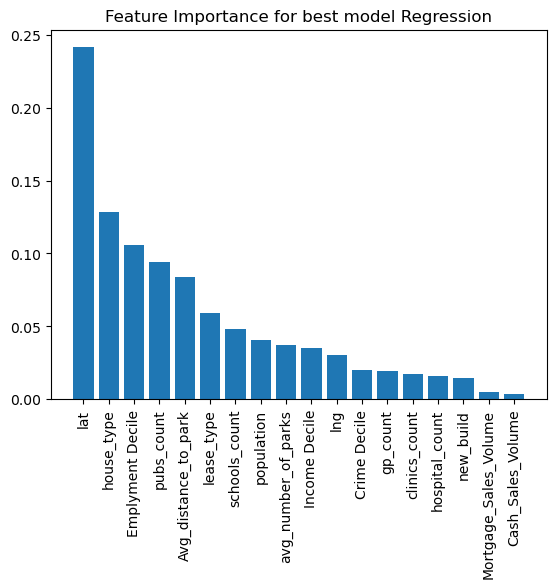

In [46]:
best_model.fit(X_train,Y_train)
# Compute feature importances
importances = best_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance for best model Regression")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()